# YLE Cage trial simulation script

20-02-24

Katie Willis 

Katie.willis@imperial.ac.uk

___

This file contains the code used to simulate the experimental cage trial associated with the publication and for parameter inference based on Approximate Bayesian Inference.



## Setup

In [61]:
] activate ./Environment

  Activating project at `~/Library/CloudStorage/OneDrive-ImperialCollegeLondon/PhD work/Drive_modelling/Projects/YLE_Ignacio/GithubCode/Environment`


In [62]:
] status

Status `~/Library/CloudStorage/OneDrive-ImperialCollegeLondon/PhD work/Drive_modelling/Projects/YLE_Ignacio/GithubCode/Environment/Project.toml`
⌃ [336ed68f] CSV v0.10.12
  [a93c6f00] DataFrames v1.6.1
  [8bb1440f] DelimitedFiles v1.9.1
  [31c24e10] Distributions v0.25.109
  [e850a1a4] GpABC v0.1.1
⌃ [033835bb] JLD2 v0.4.45
⌃ [0db19996] NBInclude v2.3.0
⌃ [91a5bcdd] Plots v1.39.0
⌃ [d330b81b] PyPlot v2.11.2
⌃ [24249f21] SymPy v2.0.1
  [8ba89e20] Distributed
  [37e2e46d] LinearAlgebra
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [63]:
using NBInclude
@nbinclude("./Environment/Setup.ipynb");
@nbinclude("./YLEModel.ipynb");

In [64]:
using Distributions
using Random

## Empirical data

In [67]:
#Cage time series data
A_nWTMale=[300,146,127,102,92,82]
A_nWTFemale=[300,170,175,215,238,257]
A_Rest=[300,284,298,283,270,261]
A_RelnWTFemales=[1.0,0.567,0.583,0.717,0.793,0.857]
A_Total=[900,600,600,600,600,600]
A_FreqMales=A_nWTMale./(A_Total.-300)

B_nWTMale=[300,130,114,86,79,43]
B_nWTFemale=[300,176,189,236,252,260]
B_Rest=[300,294,297,278,269,297]
B_RelnWTFemales=[1.0,0.587,0.630,0.787,0.840,0.867]
B_Total=[900,600,600,600,600,600]
B_FreqMales=B_nWTMale./(B_Total.-300);

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


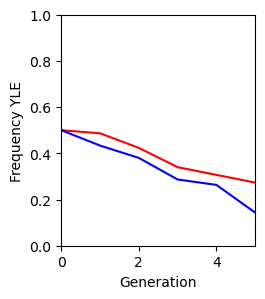

In [15]:
#Plot YLE frequency
f1 = PyPlot.figure(figsize=(2.5,3),frameon=false)

PyPlot.plot(0:5,A_FreqMales,"red")
PyPlot.plot(0:5,B_FreqMales,"blue")
#PyPlot.plot(2:(8+1),WT_egg)            
            
PyPlot.xlim([0,5])
PyPlot.ylim([0,1])
PyPlot.xlabel("Generation",size=10)
PyPlot.ylabel("Frequency YLE",size=10)

PyPlot.show()


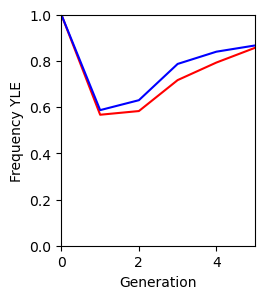

In [16]:
#Relative no. females
f1 = PyPlot.figure(figsize=(2.5,3),frameon=false)

PyPlot.plot(0:5,A_RelnWTFemales,"red")
PyPlot.plot(0:5,B_RelnWTFemales,"blue")
#PyPlot.plot(2:(8+1),WT_egg)            
            
PyPlot.xlim([0,5])
PyPlot.ylim([0,1])
PyPlot.xlabel("Generation",size=10)
PyPlot.ylabel("Frequency YLE",size=10)

PyPlot.show()


In [23]:
#Fertility data
egg_count_csv = CSV.File("./EggLaying.csv");
egg_count_df = DataFrame(egg_count_csv);

larvae_count_csv = CSV.File("./NLarvae.csv");
larvae_count_df = DataFrame(larvae_count_csv);


In [73]:
#Egg indexing - where WT and YLE are combined
Egg_array_index = [1 1 1 1 1 1;
                    1 1 1 1 1 1;
                    1 1 1 1 1 1;
                    1 1 1 1 1 1;
                    1 1 1 1 1 1;
                    1 1 1 1 1 1;
                    1 1 1 1 1 1;
                    1 1 1 1 1 1;
                    1 1 1 1 1 1;
                    1 1 1 1 1 1;
                    1 1 1 1 1 1;
                    1 1 1 1 1 1]
Egg_array_list = [vcat(collect(egg_count_df[!,"WT"]),collect(egg_count_df[!,"YLE"]))]

1-element Vector{Vector{Int64}}:
 [0, 130, 86, 185, 119, 117, 117, 94, 84, 167  …  109, 170, 128, 84, 137, 200, 163, 159, 144, 136]

## Simulate cage trial

### Define model

In [69]:
#Define all alleles and genotypes 

A_alleles = ["A","a","α"];
#A = target site
#a = edit 1
#α = edit 2

Y_genotypes = ["Y","y"];
#Y = WT
#y = construct

#Define all allele and genotypes in females
falleles = A_alleles
genotypes_f = []
for i in 1:length(falleles)
    allele1 = falleles[i]
    for j in i:length(falleles)
        allele2 = falleles[j]
        push!(genotypes_f,([allele1 allele2]))
    end
end;
        
#Define all allele combos and genotypes in males
#For males there are two options for Y, therefore double the number of alleles and genotypes
malleles = []
for A in A_alleles
    for Y in Y_genotypes
        push!(malleles,(A, Y))
    end
end
genotypes_m = []
for i in genotypes_f
    allele1 = i[1]
    allele2 = i[2]
    for yallele in Y_genotypes
        push!(genotypes_m,([allele1 allele2 yallele]))
    end
end

In [70]:
#Define symbols (don't change)
saf, haf, sαf, hαf, saαf, sam, ham, sαm, hαm, saαm, c, j, p, u, q, sy = Sym("saf haf sαf hαf saαf sam ham sαm hαm saαm c j p u q sy")

#Read in genotypes from storage
genotypes_f_string = readdlm("./YLE/YLE_genotypes_f.csv", ',', String,header=false);
genotypes_m_string = readdlm("./YLE/YLE_genotypes_m.csv", ',', String,header=false);

#Define dictionary for indexing 
index_dict_f = Dict()
[index_dict_f[genotypes_f_string[i]] = i for i in 1:length(genotypes_f_string)]
index_dict_f

index_dict_m = Dict()
[index_dict_m[genotypes_m_string[i]] = i for i in 1:length(genotypes_m_string)]
index_dict_m

#Read in and convert data back to IC_F
flattened_ic_f = readdlm("./YLE/YLE_inheritance_f.csv", ',', String,header=true)[1]
flattened_ic_f = convert(Array{Any}, flattened_ic_f)
flattened_ic_f[:,1] = [index_dict_f[i] for i in flattened_ic_f[:,1]]
flattened_ic_f[:,2] = [index_dict_m[i] for i in flattened_ic_f[:,2]]
flattened_ic_f[:,3:end] = eval.(Meta.parse.(flattened_ic_f[:,3:end]))
ic_f = Array{Any}(undef,length(genotypes_f_string),length(genotypes_m_string),length(genotypes_f_string))
for i in 1:length(flattened_ic_f[:,1])
    mother,father = flattened_ic_f[i,1:2]
    ic_f[mother,father,:] = flattened_ic_f[i,3:end]
end
ic_f = Sym.(ic_f);

#Read in and convert data back to IC_M
flattened_ic_m = readdlm("./YLE/YLE_inheritance_m.csv", ',', String,header=true)[1]
flattened_ic_m = convert(Array{Any}, flattened_ic_m)
flattened_ic_m[:,1] = [index_dict_f[i] for i in flattened_ic_m[:,1]]
flattened_ic_m[:,2] = [index_dict_m[i] for i in flattened_ic_m[:,2]]
flattened_ic_m[:,3:end] = eval.(Meta.parse.(flattened_ic_m[:,3:end]))
ic_m = Array{Any}(undef,length(genotypes_f_string),length(genotypes_m_string),length(genotypes_m_string))
for i in 1:length(flattened_ic_m[:,1])
    mother,father = flattened_ic_m[i,1:2]
    ic_m[mother,father,:] = flattened_ic_m[i,3:end]
end
ic_m = Sym.(ic_m);

#Read in fitness from storage
fitness_f = readdlm("./YLE/YLE_fitness_f.csv", ',', String,header=true)[1]
fitness_f = convert(Array{Any}, fitness_f[:,2])
fitness_f = eval.(Meta.parse.(fitness_f))
fitness_f = Sym.(fitness_f)

fitness_m = readdlm("./YLE/YLE_fitness_m.csv", ',', String,header=true)[1]
fitness_m = convert(Array{Any}, fitness_m[:,2])
fitness_m = eval.(Meta.parse.(fitness_m))
fitness_m = Sym.(fitness_m);

In [71]:
# Define inheritance and fitness params
pdict = Dict()
pdict[saf]=1.0
pdict[haf]=1.0
pdict[sαf]=1.0
pdict[hαf]=0.0
pdict[saαf]=1.0
pdict[sam]=0.0
pdict[ham]=0.0
pdict[sαm]=0.0
pdict[hαm]=0.0
pdict[saαm]=0.0

pdict[c]=0.930
pdict[j]=0.043
pdict[p]=0.0 #proportion dominant
pdict[u]=1.0
pdict[q]=0.0 #proportion dominant
pdict[sy]=0.0

# Save params
subs_list = [(p,pdict[p]) for p in keys(pdict)];
opt_subs_pdict = deepcopy(pdict)
opt_subs_list = [(param,opt_subs_pdict[param]) for param in keys(pdict)];

In [72]:
#inheritance
Nf = length(ic_f[1,1,:])
Nm = length(ic_m[1,1,:])

ic_vals = Array{Any,3}(nothing,Nf,Nm,Nf)
for i in 1:Nf
    ic_vals[i,:,:] = ic_f[i,:,:].subs(opt_subs_list)
end
ic_f_vals = Array{Float64}(ic_vals);

#inheritance
ic_vals = Array{Any,3}(nothing,Nf,Nm,Nm)
for i in 1:Nf
    ic_vals[i,:,:] = ic_m[i,:,:].subs(opt_subs_list)
end
ic_m_vals = Array{Float64}(ic_vals);


In [25]:
#Simulation function
function run_sim(ic_f,ic_m,Egg_array_list,Egg_array_index;
        starting_pop = 300,
        n_released_males = 300, 
        n_released_females = 0, 
        first_release = 1, 
        gen = 5,
        hatching = 0.9, #Hatching probability of those which do lay hatchable eggs - check if genotype specific
        larvae_surv = 0.89, #Probability of larvae pupating - check if genotype specific
        mating_prob = 0.85, #Probability of pupae surviving to mate
        yle_cost = 0.0,
        yle_cost_larvae = 0.0
        )
        
    #____________________________________________________________
    #Storage for time series output - initiate starting population 
    total_egg_count = []
    total_YLE_n = [n_released_males]
    n_WT_females = [starting_pop-n_released_females]
    freq_res = [0.0]
    n_fem_a = []
    n_fem_alpha = []

    #____________________________________________________________
    #Starting population
    #Genotype categories = WT/WT, WT/CONSTRUCT, WT/R, CONSTRUCT/CONSTRUCT, CONSTRUCT/R, R/R
    n_male_pupae = [starting_pop,0,0,0,0,0,0,0,0,0,0,0];
    n_female_pupae = [starting_pop,0,0,0,0,0];

    for t in 1:gen

        #____________________________________________________________
        # Generate the number of females of each genotype which mate 
        ## This is a combination of
            ## the number of female pupae in the cage
            ## the probability of each pupae surviving to adulthood: currently equal for all genotypes
            ## the probability of each female mating: currently equal for all genotypes
        n_mating_female = [0,0,0,0,0,0]
        #Draw number of mating females from n_pupae of each genotypes from a binomial distribution
            ## This is done separately for the group of females of each genotype
        for g in 1:6  
            dist = Binomial(n_female_pupae[g],mating_prob)
            n_mating_female[g] = rand(dist)
        end

        #____________________________________________________________
        #Apply female costs (no mating since they are intersex)
        #Currently assumes that all females with both types of mutation are completely infertile
        n_mating_female[[2,4,5,6]] .= 0.0
        #____________________________________________________________
        
        
        # Generate the number of males of each genotype which enter the mating pool
        #____________________________________________________________
        #Release male and female heterozygotes for the construct into the cage given a certain release generation and release size        
        if (t == first_release)
            n_male_pupae[4] = n_male_pupae[4] + n_released_males #Release hets for dominant alelle and carrying YLE
        end
        
        #Generate the number of males of each genotype which enter the mating pool
        ## This is a combination of
            ## the number of male pupae in the cage
            ## the probability of each male pupae surviving to adulthood: currently equal for all genotypes
        ## We assume all males can mate with any female, and males can mate mutliple times: 
            ##there is no reduced mating success by genotype
        n_mating_male = [0,0,0,0,0,0,0,0,0,0,0,0]
        
        #Draw number of surviving males from n_pupae of each genotypes from a binomial distribution
            ## This is done separately for the group of males of each genotype
        for g in 1:12
            dist = Binomial(n_male_pupae[g],mating_prob)
            n_mating_male[g] = rand(dist)
        end

        #____________________________________________________________
        #Apply male costs (reduce proportion mating due to reduced competition)
        #Currently assumes that all females with both types of mutation are completely infertile
        n_mating_male = Float64.(n_mating_male)
        n_mating_male[[2,4,6,8,10,12]] .= n_mating_male[[2,4,6,8,10,12]].*(1 .-yle_cost)
        freq_mating_males = n_mating_male./sum(n_mating_male)
        #____________________________________________________________
        
        #____________________________________________________________
        #Check whether there are both adult males and females in the population
            ## Otherwise end the simulation
        if (sum(n_mating_male) .== 0) | (sum(n_mating_female) .== 0)
            #CENSUS? 
            push!(total_egg_count,0)
            push!(total_construct_freq,NaN)
            return(total_egg_count,total_construct_freq,freq_res)
        end
        
        #____________________________________________________________
        #Produce zygotes from mating pairs
        n_f_eggs_store = [0,0,0,0,0,0]
        n_m_eggs_store = [0,0,0,0,0,0,0,0,0,0,0,0]

        #Create the mating pairs
        ## For each female genotype, draw the male partners from a multinomial distribution parameterised by
            ## the number of females of the genotype in the cage
            ## the frequency of males of each genotype in the cage
        for n_females_genotype in 1:6 
            dist = Multinomial(n_mating_female[n_females_genotype], freq_mating_males) #Not sure if this is correct - use probability or sample with replacement? 
            mating_pairs = rand(dist)
            #Create the eggs produced by each mating pair:
            #The total number of eggs for each mating pair is drawn from an array of observed egg numnbers
            #The number of each egg is drawn from a multinomial distribution parameterised by 
                #the number of eggs 
                #the probability of producing each type of offsping from the inheritance cube
            for n_males_genotype in 1:12 #Sex will be determined by the sperm genotype...
                #Select the egg array to draw from depending on the cross
                Egg_array_index_pair = Egg_array_index[n_males_genotype,n_females_genotype]

                for i in 1:mating_pairs[n_males_genotype]
                    f_dist = Multinomial(rand(Egg_array_list[Egg_array_index_pair]), ic_f_vals[n_females_genotype,n_males_genotype,:].*2) #LINE OF THE FEMALE INHERITANCE CUBE
                    m_dist = Multinomial(rand(Egg_array_list[Egg_array_index_pair]), ic_m_vals[n_females_genotype,n_males_genotype,:].*2) #LINE OF THE MALE INHERITANCE CUBE

                    #Count the total number of eggs produced per cage
                    n_f_eggs_store = n_f_eggs_store .+ rand(f_dist)
                    n_m_eggs_store = n_m_eggs_store .+ rand(m_dist)
                end
            end
        end

        #CENSUS the number of eggs
        #Census the total number of eggs from a single round of laying
        push!(total_egg_count,sum(n_f_eggs_store)+sum(n_m_eggs_store))

        #____________________________________________________________
        #Let all eggs hatch into larvae and grow to pupae
        n_f_pupae_store = Array{Int64}(undef,(6,1))
        n_m_pupae_store = Array{Int64}(undef,(12,1))
        #Its possible we want hatching to depend on the parental cross...
            #if so may want to include the hatching in the above...
        #Draw number of larvae from n_eggs of each genotypes and sex from a binomial distribution
            ## This is done separately for the group of males and females of each genotype
        for g in 1:6
            dist = Binomial(n_f_eggs_store[g,1],hatching*larvae_surv)
            n_f_pupae_store[g,1] = rand(dist)
        end
        
        for g in 1:12
            if g in [2,4,6,8,10,12]
                dist = Binomial(n_m_eggs_store[g,1],hatching*larvae_surv*(1-yle_cost_larvae))
            else
                dist = Binomial(n_m_eggs_store[g,1],hatching*larvae_surv)
            end
            n_m_pupae_store[g,1] = rand(dist)
        end

        #____________________________________________________________
        #Produce new generation by randomly selecting 600 pupae to seed the next cage
            ## Produce a vector containing numbers 1:6 representing the 12 genotypes of both sexes, 
            ## each repeated the number of times they are present in the pupae population. 
            ## This is to allow down sampling by randomly selecting X individuals from the egg pool without replacement.
        dist = vcat(fill.(collect(1:18), vcat(n_f_pupae_store[:,1],n_m_pupae_store[:,1]))...)

        total_n_pupae = sum(vcat(n_f_pupae_store[:,1],n_m_pupae_store[:,1]))
        if total_n_pupae > 600
            sampled_pupae = sample(dist,Int64(600),replace=false);
            n_pupae = [count(==(i), sampled_pupae) for i in collect(1:18)]
        else
            n_pupae = vcat(n_f_pupae_store[:,1],n_m_pupae_store[:,1])
        end

        n_female_pupae = n_pupae[1:6]
        n_male_pupae = n_pupae[7:18]
        
        #____________________________________________________________
        #Count the number of YLE male pupae and WT female exactly
        push!(total_YLE_n,(n_male_pupae[2]+
                                n_male_pupae[4]+
                                n_male_pupae[6]+
                                n_male_pupae[8]+
                                n_male_pupae[10]+
                                n_male_pupae[12]))
        
        push!(n_WT_females,(n_female_pupae[1]))
        
        push!(n_fem_a,(n_female_pupae[2]+
                                n_female_pupae[4]+
                                n_female_pupae[5]))
        
        push!(n_fem_alpha,((n_female_pupae[3]/2)+
                               (n_female_pupae[5]/2)+
                                (n_female_pupae[6])+
                                (n_male_pupae[5]/2)+
                               (n_male_pupae[6]/2)+
                                (n_male_pupae[9]/2)+
                               (n_male_pupae[10]/2)+
                                n_male_pupae[11]+
                                n_male_pupae[12]))

    end

    return([total_YLE_n,n_WT_females,n_fem_a,n_fem_alpha])
end

run_sim (generic function with 1 method)

### ABC estimation

In [74]:
function euclidean_distance(ts1, ts2)
    return norm(ts1 - ts2)
end

euclidean_distance (generic function with 1 method)

In [75]:
function abc(data,tolerance,nsims;prior=Uniform(0,1))
    
    gen = 5
    ts1 = vcat(A_FreqMales,B_FreqMales)

    yle_cost_posterior = []
    yle_cost_distance = []
    yle_cost_data = []
    for i in 1:nsims
        yle_cost = rand(prior)
        run1 = run_sim(ic_f,ic_m,Egg_array_list,Egg_array_index,gen=gen,yle_cost=yle_cost)
        run2 = run_sim(ic_f,ic_m,Egg_array_list,Egg_array_index,gen=gen,yle_cost=yle_cost)
        sim = vcat(run1[1]./(A_Total.-300),run2[1]./(A_Total.-300))
        push!(yle_cost_distance,euclidean_distance(data,sim))
        push!(yle_cost_posterior,yle_cost)
        push!(yle_cost_data,sim)
    end

    TH = sort(yle_cost_distance)[Int64(floor(nsims*tolerance))]
    yle_cost_posterior_top = yle_cost_posterior[yle_cost_distance .< TH];

    return(yle_cost_posterior_top,yle_cost_posterior,yle_cost_distance,yle_cost_data)
end

function abc_both(data,tolerance,nsims)
    
    gen = 5
    ts1 = vcat(A_FreqMales,B_FreqMales)

    yle_cost_posterior = []
    yle_cost_distance = []
    yle_cost_data = []
    for i in 1:(nsims/2)
        yle_cost = rand()
        run1 = run_sim(ic_f,ic_m,Egg_array_list,Egg_array_index,gen=gen,yle_cost=yle_cost)
        run2 = run_sim(ic_f,ic_m,Egg_array_list,Egg_array_index,gen=gen,yle_cost=yle_cost)
        sim = vcat(run1[1]./(A_Total.-300),run2[1]./(A_Total.-300))
        push!(yle_cost_distance,euclidean_distance(data,sim))
        push!(yle_cost_posterior,yle_cost)
        push!(yle_cost_data,sim)
    end
    
    for i in 1:(nsims/2)
        yle_cost = rand()
        run1 = run_sim(ic_f,ic_m,Egg_array_list,Egg_array_index,gen=gen,yle_cost_larvae=yle_cost)
        run2 = run_sim(ic_f,ic_m,Egg_array_list,Egg_array_index,gen=gen,yle_cost_larvae=yle_cost)
        sim = vcat(run1[1]./(A_Total.-300),run2[1]./(A_Total.-300))
        push!(yle_cost_distance,euclidean_distance(data,sim))
        push!(yle_cost_posterior,yle_cost)
        push!(yle_cost_data,sim)
    end
    

    TH = sort(yle_cost_distance)[Int64(floor(nsims*tolerance))]
    yle_cost_posterior_top = yle_cost_posterior[yle_cost_distance .< TH];
    indexes = collect(1:nsims)[yle_cost_distance .< TH]
    model1_indexes = indexes[indexes .< nsims/2]
    model2_indexes = indexes[indexes .> nsims/2]

    yle_cost_posterior_top1 = yle_cost_posterior[model1_indexes]
    yle_cost_posterior_top2 = yle_cost_posterior[model2_indexes]
    
    return(yle_cost_posterior_top1,yle_cost_posterior_top2)
end

function abc_larvae(data,tolerance,nsims;prior=Uniform(0,1))
    
    gen = 5
    ts1 = vcat(A_FreqMales,B_FreqMales)

    yle_cost_posterior = []
    yle_cost_distance = []
    yle_cost_data = []
    for i in 1:nsims
        yle_cost = rand(prior)
        run1 = run_sim(ic_f,ic_m,Egg_array_list,Egg_array_index,gen=gen,yle_cost_larvae=yle_cost)
        run2 = run_sim(ic_f,ic_m,Egg_array_list,Egg_array_index,gen=gen,yle_cost_larvae=yle_cost)
        sim = vcat(run1[1]./(A_Total.-300),run2[1]./(A_Total.-300))
        push!(yle_cost_distance,euclidean_distance(data,sim))
        push!(yle_cost_posterior,yle_cost)
        push!(yle_cost_data,sim)
    end

    TH = sort(yle_cost_distance)[Int64(floor(nsims*tolerance))]
    yle_cost_posterior_top = yle_cost_posterior[yle_cost_distance .< TH];

    return(yle_cost_posterior_top,yle_cost_posterior,yle_cost_distance,yle_cost_data)
end

function abc2(data,tolerance,nsims)
    
    gen = 5
    ts1 = vcat(A_FreqMales,B_FreqMales)
    
    # Define inheritance and fitness params
    pdict = Dict()
    pdict[saf]=1.0
    pdict[haf]=1.0
    pdict[sαf]=1.0
    pdict[hαf]=0.0
    pdict[saαf]=1.0
    pdict[sam]=0.0
    pdict[ham]=0.0
    pdict[sαm]=0.0
    pdict[hαm]=0.0
    pdict[saαm]=0.0

    pdict[c]=0.930
    pdict[j]=0.043
    pdict[p]=0.0 #proportion dominant
    pdict[u]=1
    pdict[q]=0.0 #proportion dominant
    pdict[sy]=0.0

    pdict[p]=0.8 #proportion dominant
    pdict[u]=0.1
    pdict[q]=0.8 #proportion dominant

    yle_cost_posterior = []
    yle_cost_distance = []
    yle_cost_data = []
    
    p_cost_posterior = []
    q_cost_posterior = []
    u_cost_posterior = []
    
    for i in 1:nsims
        yle_cost = rand()
        pdict[p]=1 #proportion dominant
        pdict[u]=rand()
        pdict[q]=1 #proportion dominant
        
        # Save params
        subs_list = [(p,pdict[p]) for p in keys(pdict)];
        opt_subs_pdict = deepcopy(pdict)
        opt_subs_list = [(param,opt_subs_pdict[param]) for param in keys(pdict)];
        
        #inheritance
        Nf = length(ic_f[1,1,:])
        Nm = length(ic_m[1,1,:])

        ic_vals = Array{Any,3}(nothing,Nf,Nm,Nf)
        for i in 1:Nf
            ic_vals[i,:,:] = ic_f[i,:,:].subs(opt_subs_list)
        end
        ic_f_vals = Array{Float64}(ic_vals);

        #inheritance
        ic_vals = Array{Any,3}(nothing,Nf,Nm,Nm)
        for i in 1:Nf
            ic_vals[i,:,:] = ic_m[i,:,:].subs(opt_subs_list)
        end
        ic_m_vals = Array{Float64}(ic_vals);
        
        run1 = run_sim(ic_f,ic_m,Egg_array_list,Egg_array_index,gen=gen,yle_cost=yle_cost)
        run2 = run_sim(ic_f,ic_m,Egg_array_list,Egg_array_index,gen=gen,yle_cost=yle_cost)
        sim = vcat(run1[1]./(A_Total.-300),
            run2[1]./(A_Total.-300),
            run1[2]./300,
            run2[2]./300,
            run[4][1:3]./(A_Total[2:end-1]),    
            run[4][1:3]./(A_Total[2:end-1]))
        push!(yle_cost_distance,euclidean_distance(data,sim))
        push!(yle_cost_posterior,yle_cost)
        push!(yle_cost_data,sim)
        push!(p_cost_posterior,pdict[p])
        push!(q_cost_posterior,pdict[q])
        push!(u_cost_posterior,pdict[u])
        
    end

    TH = sort(yle_cost_distance)[Int64(floor(nsims*tolerance))]
    yle_cost_posterior_top = yle_cost_posterior[yle_cost_distance .< TH];
    p_cost_posterior_top = p_cost_posterior[yle_cost_distance .< TH];
    q_cost_posterior_top = q_cost_posterior[yle_cost_distance .< TH];
    u_cost_posterior_top = u_cost_posterior[yle_cost_distance .< TH];

    return(yle_cost_posterior_top,
        p_cost_posterior_top,
        q_cost_posterior_top,
        u_cost_posterior_top,yle_cost_posterior,yle_cost_distance,yle_cost_data)
end


function cross_val_abc(yle_cost_posterior,yle_cost_data,tolerance,nsims,nval)
    meds = []
    true_cost = []
    for ni in 1:nval
        i = rand(1:nsims)
        yle_cost_true = yle_cost_posterior[i]
        yle_data_true = yle_cost_data[i]
        test_indexes = setdiff(1:nsims, i)
        yle_cost_distance_val = [euclidean_distance(yle_data_true,j) for j in yle_cost_data[test_indexes]]
        TH = sort(yle_cost_distance_val)[Int64(floor(nsims*tolerance))]
        yle_cost_posterior_val_top = yle_cost_posterior[test_indexes][yle_cost_distance_val .< TH]
        push!(meds,((median(yle_cost_posterior_val_top) - yle_cost_true)^2))
        push!(true_cost,yle_cost_true)
    end
    prediction_error = sum(meds)/var(true_cost)
    return(prediction_error)
end

    

cross_val_abc (generic function with 1 method)

#### Estimation

In [45]:
nsims = 10000
tolerance = 0.05
data = vcat(A_FreqMales,B_FreqMales)

12-element Vector{Float64}:
 0.5
 0.4866666666666667
 0.42333333333333334
 0.34
 0.30666666666666664
 0.2733333333333333
 0.5
 0.43333333333333335
 0.38
 0.2866666666666667
 0.2633333333333333
 0.14333333333333334

In [46]:
yle_cost_posterior_top,yle_cost_posterior,yle_cost_distance,yle_cost_data = abc(data,tolerance,nsims);
println("Point estimate: ",median(yle_cost_posterior_top))
prediction_error = cross_val_abc(yle_cost_posterior,yle_cost_data,tolerance,nsims,100)
println("Prediction error: ",prediction_error)

Point estimate: 0.2198188968555015
Prediction error: 2.8032842543305807


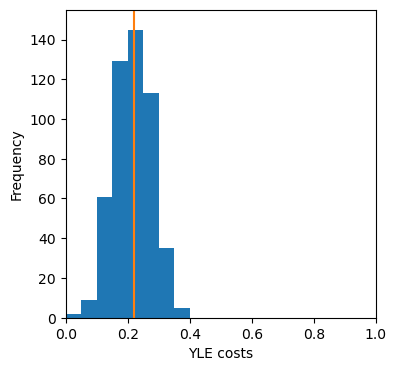

In [47]:
f1 = PyPlot.figure(figsize=(4,4),frameon=false)

PyPlot.hist(yle_cost_posterior_top,bins=collect(0:0.05:1))
PyPlot.plot([median(yle_cost_posterior_top),median(yle_cost_posterior_top)],[0.0,155])

PyPlot.xlim([0,1])
PyPlot.ylim([0,155])
PyPlot.xlabel("YLE costs",size=10)
PyPlot.ylabel("Frequency",size=10)
PyPlot.savefig("../figures/ABC_YLEInference_Competition.pdf",bbox_inches = "tight")


In [48]:
nsims = 10000
tolerance = 0.05

0.05

In [49]:
Random.seed!(1)
yle_cost_posterior_top,yle_cost_posterior,yle_cost_distance,yle_cost_data = abc(data,tolerance,nsims,prior=Uniform(-1,1));

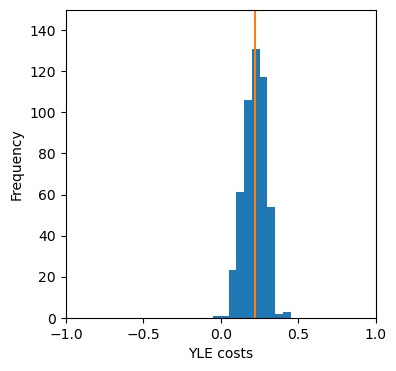

In [50]:
f1 = PyPlot.figure(figsize=(4,4),frameon=false)

PyPlot.hist(yle_cost_posterior_top,bins=collect(-1:0.05:1))
PyPlot.plot([median(yle_cost_posterior_top),median(yle_cost_posterior_top)],[0.0,155])

PyPlot.xlim([-1,1])
PyPlot.ylim([0,150])
PyPlot.xlabel("YLE costs",size=10)
PyPlot.ylabel("Frequency",size=10)
PyPlot.savefig("../figures/ABC_YLEInference_Competition_negprior.pdf",bbox_inches = "tight")


In [51]:
println("Point estimate: ",median(yle_cost_posterior_top))
println("Prediction error: ",prediction_error)
println(quantile(yle_cost_posterior_top, [0.025, 0.975]))

Point estimate: 0.22129490498101423
Prediction error: 2.8032842543305807
[0.07504180366594414, 0.3327401148597359]


#### Prediction error

In [52]:
data = vcat(A_FreqMales,B_FreqMales)
tolerance = 0.05
nsims = 10000
Random.seed!(1)
yle_cost_posterior_top,yle_cost_posterior,yle_cost_distance,yle_cost_data = abc(data,tolerance,nsims,prior=Uniform(-1,1));
println("Point estimate: ",median(yle_cost_posterior_top))


Point estimate: 0.22129490498101423


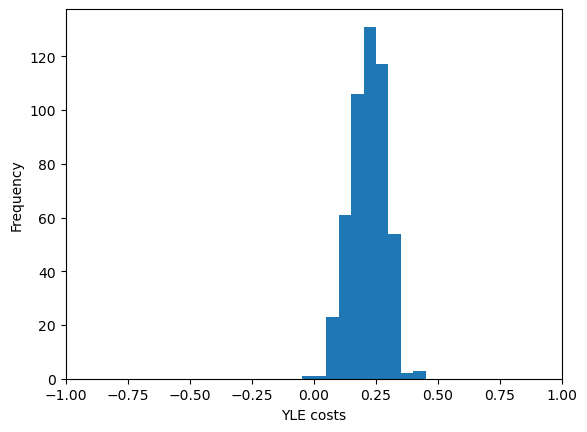

(-1.0, 1.0)

In [53]:
PyPlot.hist(yle_cost_posterior_top,bins=collect(-1:0.05:1))
PyPlot.xlabel("YLE costs",size=10)
PyPlot.ylabel("Frequency",size=10)
PyPlot.xlim([-1,1])

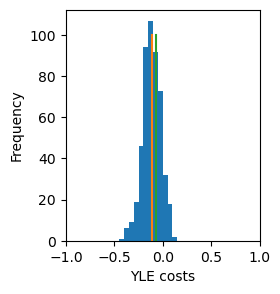

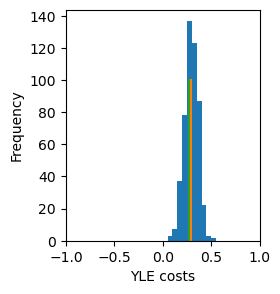

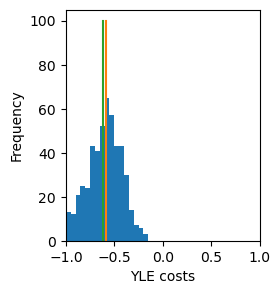

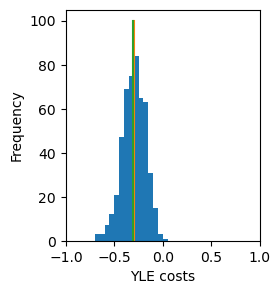

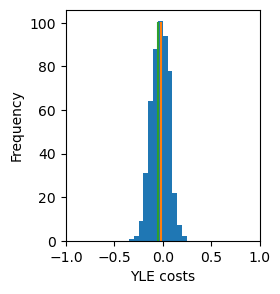

1.8044552002844265

In [54]:
nval=100
meds = []
true_cost = []

for ni in 1:nval
    i = rand(1:nsims)
    yle_cost_true = yle_cost_posterior[i]
    yle_data_true = yle_cost_data[i]
    test_indexes = setdiff(1:nsims, i)
    yle_cost_distance_val = [euclidean_distance(yle_data_true,j) for j in yle_cost_data[test_indexes]]
    TH = sort(yle_cost_distance_val)[Int64(floor(nsims*tolerance))]
    yle_cost_posterior_val_top = yle_cost_posterior[test_indexes][yle_cost_distance_val .< TH]
    push!(meds,((median(yle_cost_posterior_val_top) - yle_cost_true)^2))
    push!(true_cost,yle_cost_true)
    if ni <= 5
        f1 = PyPlot.figure(figsize=(2.5,3),frameon=false)
        PyPlot.hist(yle_cost_posterior_val_top,bins=collect(-1:0.05:1))
        PyPlot.plot([median(yle_cost_posterior_val_top),median(yle_cost_posterior_val_top)],[0,100])
        PyPlot.plot([median(yle_cost_true),median(yle_cost_true)],[0,100])
        PyPlot.xlabel("YLE costs",size=10)
        PyPlot.ylabel("Frequency",size=10)
        PyPlot.xlim([-1,1])
    end
end
prediction_error = sum(meds)/var(true_cost)


In [55]:
Random.seed!(1)
nval=499
Tols = [0.9,0.75,0.5,0.25,0.1,0.05,0.02,0.01]
Nsims = [500, 1000,5000,10000,50000]
NsimsTols_error = []
for nsims in Nsims
    Tols_error = []
    println("No. simulations: ",nsims)
    for tolerance in Tols
        println("Tolerance: ",tolerance)
        yle_cost_posterior_top,yle_cost_posterior,yle_cost_distance,yle_cost_data = abc(data,tolerance,nsims,prior=Uniform(-1,1));
        println("Point estimate: ",median(yle_cost_posterior_top))
        prediction_error = cross_val_abc(yle_cost_posterior,yle_cost_data,tolerance,nsims,nval)
        println("Prediction error: ",prediction_error)
        println(" ")
        push!(Tols_error,prediction_error)
    end
    push!(NsimsTols_error,Tols_error)
end


No. simulations: 500
Tolerance: 0.9
Point estimate: 0.12090733961604583
Prediction error: 395.08330954235987
 
Tolerance: 0.75
Point estimate: 0.28678222984404855
Prediction error: 203.32895312199994
 
Tolerance: 0.5
Point estimate: 0.3323046618826824
Prediction error: 75.8477011859397
 
Tolerance: 0.25
Point estimate: 0.2270038624433257
Prediction error: 21.12556504837598
 
Tolerance: 0.1
Point estimate: 0.2091418812453374
Prediction error: 12.100147177766337
 
Tolerance: 0.05
Point estimate: 0.20944829393287234
Prediction error: 12.023796942358906
 
Tolerance: 0.02
Point estimate: 0.18535176396109754
Prediction error: 18.65092222961017
 
Tolerance: 0.01
Point estimate: 0.19771474441891979
Prediction error: 11.829398191182886
 
No. simulations: 1000
Tolerance: 0.9
Point estimate: 0.10896235238213237
Prediction error: 346.75778448310206
 
Tolerance: 0.75
Point estimate: 0.2931233045909505
Prediction error: 206.43044794490902
 
Tolerance: 0.5
Point estimate: 0.3367520637126309
Predictio

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


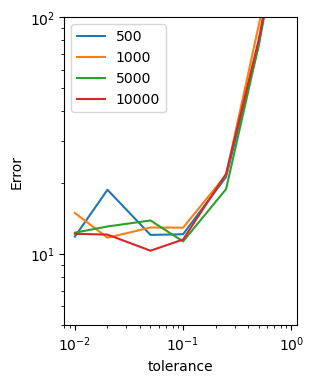

In [56]:
f1 = PyPlot.figure(figsize=(3,4),frameon=false)
c=1
for nsims in Nsims[1:end-1]
    PyPlot.plot(reverse(Tols), reverse(NsimsTols_error[c]),label=nsims)
    PyPlot.xlabel("tolerance",size=10)
    PyPlot.ylabel("Error",size=10)
    c=c+1
end
PyPlot.yscale("log")
PyPlot.ylim(5,100)
PyPlot.xscale("log")
PyPlot.legend()
PyPlot.show()
PyPlot.savefig("../figures/ABC_error.pdf",bbox_inches = "tight")


### Example simulations with data

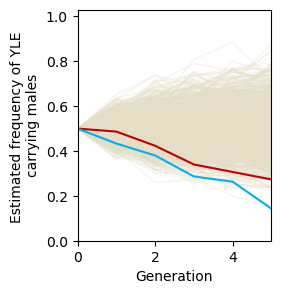

In [29]:
#Frequency of YLE carrying males, with no cost
Random.seed!(101)
gen = 5
End_freq = []

#Larvae frequency
f1 = PyPlot.figure(figsize=(2.5,3),frameon=false)

#drive construct
n=0
for i in 1:1000
    run = run_sim(ic_f_vals,ic_m_vals,Egg_array_list,Egg_array_index,gen=gen)
    freq_y = run[1]./(A_Total.-300)
    PyPlot.plot(0:length(run[1])-1,freq_y,c="#E5DEC6","-",linewidth = 1,alpha=0.3)
    push!(End_freq,freq_y[end])
end

PyPlot.plot(0:5,A_FreqMales,"#c00000")
PyPlot.plot(0:5,B_FreqMales,"#00b0f0")      

PyPlot.xlim([0,5])
PyPlot.ylim([0,1.03])
PyPlot.xlabel("Generation",size=10)
PyPlot.ylabel("Estimated frequency of YLE \ncarrying males",size=10)

PyPlot.show()
PyPlot.savefig("../figures/CageSim_RelFreqMale.pdf",bbox_inches = "tight")


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


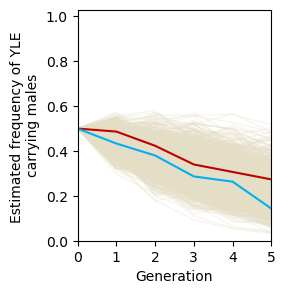

In [60]:
#Frequency of YLE carrying males, with 22% cost
Random.seed!(101)
gen = 5
End_freq = []

#Larvae frequency
f1 = PyPlot.figure(figsize=(2.5,3),frameon=false)

#drive construct
n=0
for i in 1:1000
    run = run_sim(ic_f_vals,ic_m_vals,Egg_array_list,Egg_array_index,gen=gen,yle_cost=0.22)
    freq_y = run[1]./(A_Total.-300)
    PyPlot.plot(0:length(run[1])-1,freq_y,c="#E5DEC6","-",linewidth = 1,alpha=0.3)
    push!(End_freq,freq_y[end])
end

PyPlot.plot(0:5,A_FreqMales,"#c00000")
PyPlot.plot(0:5,B_FreqMales,"#00b0f0")      

PyPlot.xlim([0,5])
PyPlot.ylim([0,1.03])
PyPlot.xticks([0,1,2,3,4,5],[0,1,2,3,4,5])
PyPlot.xlabel("Generation",size=10)
PyPlot.ylabel("Estimated frequency of YLE \ncarrying males",size=10)

PyPlot.show()
PyPlot.savefig("../figures/CageSim_RelFreqMale_adultcost.pdf",bbox_inches = "tight")


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


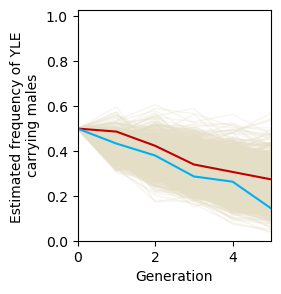

In [37]:
#Frequency of YLE carrying males, with 20% cost
Random.seed!(101)
gen = 5
End_freq = []

#Larvae frequency
f1 = PyPlot.figure(figsize=(2.5,3),frameon=false)

#drive construct
n=0
for i in 1:1000
    run = run_sim(ic_f_vals,ic_m_vals,Egg_array_list,Egg_array_index,gen=gen,yle_cost_larvae=0.20)
    freq_y = run[1]./(A_Total.-300)
    PyPlot.plot(0:length(run[1])-1,freq_y,c="#E5DEC6","-",linewidth = 1,alpha=0.3)
    push!(End_freq,freq_y[end])
end

PyPlot.plot(0:5,A_FreqMales,"#c00000")
PyPlot.plot(0:5,B_FreqMales,"#00b0f0")      
   

PyPlot.xlim([0,5])
PyPlot.ylim([0,1.03])
PyPlot.xlabel("Generation",size=10)
PyPlot.ylabel("Estimated frequency of YLE \ncarrying males",size=10)

PyPlot.show()
PyPlot.savefig("../figures/CageSim_RelFreqMale_juvcost.pdf",bbox_inches = "tight")


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


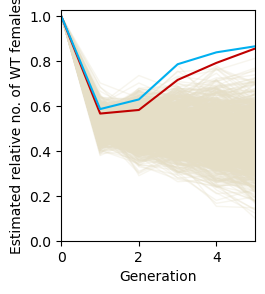

In [40]:
#Relative females, no costs 
Random.seed!(123)
gen = 5

#Larvae frequency
f1 = PyPlot.figure(figsize=(2.5,3),frameon=false)

#drive construct
n=0
for i in 1:1000
    run = run_sim(ic_f_vals,ic_m_vals,Egg_array_list,Egg_array_index,gen=gen)
    freq_y = run[2]./300
    PyPlot.plot(0:length(run[1])-1,freq_y,c="#E5DEC6","-",linewidth = 1,alpha=0.3)
end

PyPlot.plot(0:5,A_RelnWTFemales,"#c00000")
PyPlot.plot(0:5,B_RelnWTFemales,"#00b0f0")   

PyPlot.xlim([0,5])
PyPlot.ylim([0,1.03])
PyPlot.xlabel("Generation",size=10)
PyPlot.ylabel("Estimated relative no. of WT females",size=10)

PyPlot.show()
PyPlot.savefig("../figures/CageSim_NoFem.pdf",bbox_inches = "tight")


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


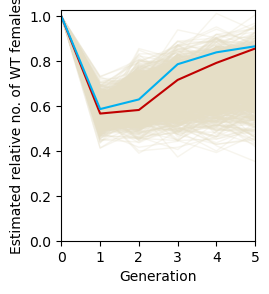

In [59]:
#Relative females, 22% cost
Random.seed!(123)
gen = 5

#Larvae frequency
f1 = PyPlot.figure(figsize=(2.5,3),frameon=false)

#drive construct
n=0
for i in 1:1000
    run = run_sim(ic_f_vals,ic_m_vals,Egg_array_list,Egg_array_index,gen=gen,yle_cost=0.22)
    freq_y = run[2]./300
    PyPlot.plot(0:length(run[1])-1,freq_y,c="#E5DEC6","-",linewidth = 1,alpha=0.3)
end

PyPlot.plot(0:5,A_RelnWTFemales,"#c00000")
PyPlot.plot(0:5,B_RelnWTFemales,"#00b0f0")    

PyPlot.xlim([0,5])
PyPlot.ylim([0,1.03])
PyPlot.xticks([0,1,2,3,4,5],[0,1,2,3,4,5])
PyPlot.xlabel("Generation",size=10)
PyPlot.ylabel("Estimated relative no. of WT females",size=10)

PyPlot.show()
PyPlot.savefig("../figures/CageSim_NoFem_adultcost.pdf",bbox_inches = "tight")



sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


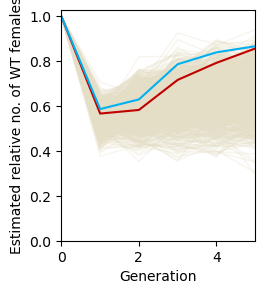

In [42]:
#Relative females, 20% cost in larvae
Random.seed!(123)
gen = 5

#Larvae frequency
f1 = PyPlot.figure(figsize=(2.5,3),frameon=false)

#drive construct
n=0
for i in 1:1000
    run = run_sim(ic_f_vals,ic_m_vals,Egg_array_list,Egg_array_index,gen=gen,yle_cost_larvae=0.20)
    freq_y = run[2]./300
    PyPlot.plot(0:length(run[1])-1,freq_y,c="#E5DEC6","-",linewidth = 1,alpha=0.3)
end

PyPlot.plot(0:5,A_RelnWTFemales,"#c00000")
PyPlot.plot(0:5,B_RelnWTFemales,"#00b0f0")    

PyPlot.xlim([0,5])
PyPlot.ylim([0,1.03])
PyPlot.xlabel("Generation",size=10)
PyPlot.ylabel("Estimated relative no. of WT females",size=10)

PyPlot.show()
PyPlot.savefig("../figures/CageSim_NoFem_larvaecost.pdf",bbox_inches = "tight")

